# Regularizing Class-wise Predictions via Self-knowledge Distillation, 20 `CVPR

#### code modified from https://github.com/alinlab/cs-kd

In [1]:
from __future__ import print_function

import argparse
import csv
import os, logging
import easydict

import numpy as np
import torch
from torch.autograd import Variable, grad
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

import models
#from utils import progress_bar, set_logging_defaults
from datasets import load_dataset

args = easydict.EasyDict({"lr": 0.1,
                         "resume": False,
                         "model": "CIFAR_ResNet18",
                         "name": '0',
                         "batch_size": 128,
                         "epoch": 200,
                         "decay": 1e-4,
                         "ngpu": 1,
                         "sgpu": 0,
                         "dataset": 'cifar100',
                         "dataroot": './data/',
                         "saveroot": './results',
                         "cls": True,
                         "temp": 4.0,
                         "lamda": 1.0})

use_cuda = torch.cuda.is_available()

best_val = 0  # best validation accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

cudnn.benchmark = True

### Dataset: CIFAR100
### Model: ResNet-18

#### trainloader 에서 pair sampling
input : [batch_size, batch_size] -> 2*B 개의 이미지

앞의 batch와 뒤의 batch의 label은 서로 일치함.

In [2]:
print('==> Preparing dataset: {}'.format(args.dataset))
trainloader, valloader = load_dataset(args.dataset, args.dataroot, 'pair', batch_size=args.batch_size)

==> Preparing dataset: cifar100
Files already downloaded and verified
Files already downloaded and verified


In [3]:
num_class = trainloader.dataset.num_classes
print('Number of train dataset: ' ,len(trainloader.dataset))
print('Number of validation dataset: ' ,len(valloader.dataset))

net = models.load_model(args.model, num_class)

if use_cuda:
    torch.cuda.set_device(args.sgpu)
    net = net.cuda()

if args.ngpu > 1:
    net = torch.nn.DataParallel(net, device_ids=list(range(args.sgpu, args.sgpu + args.ngpu)))

optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=0.9, weight_decay=args.decay)

logdir = os.path.join(args.saveroot, args.dataset, args.model, args.name)

Number of train dataset:  50000
Number of validation dataset:  10000
==> Building model: CIFAR_ResNet18
4
Using CUDA..


#### Train input example

torch.Size([256, 3, 32, 32]) torch.Size([256])


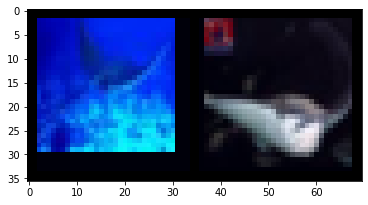

In [4]:
import torchvision
import matplotlib.pyplot as plt

inputs, targets = next(iter(trainloader))
#inputs, targets = inputs.cuda(), targets.cuda()
print(inputs.size(), targets.size())

split_idx = inputs.size(0) // 2
grid = torchvision.utils.make_grid(torch.stack((inputs[0], inputs[split_idx]), 0), normalize=True)
plt.imshow(np.transpose(grid.numpy(), (1,2,0)), interpolation='nearest')

In [5]:
class KDLoss(nn.Module):
    def __init__(self, temp_factor):
        super(KDLoss, self).__init__()
        self.temp_factor = temp_factor
        self.kl_div = nn.KLDivLoss(reduction="sum")

    def forward(self, input, target):
        log_p = torch.log_softmax(input/self.temp_factor, dim=1)
        q = torch.softmax(target/self.temp_factor, dim=1)
        loss = self.kl_div(log_p, q)*(self.temp_factor**2)/input.size(0)
        return loss

kdloss = KDLoss(args.temp)
criterion = nn.CrossEntropyLoss()

In [6]:
def val(epoch):
    global best_val
    net.eval()
    val_loss = 0.0
    correct = 0.0
    total = 0.0

    # Define a data loader for evaluating
    loader = valloader

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(loader):
            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()

            outputs = net(inputs)
            loss = torch.mean(criterion(outputs, targets))

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum().float()

#             progress_bar(batch_idx, len(loader),
#                          'Loss: %.3f | Acc: %.3f%% (%d/%d) '
#                          % (val_loss/(batch_idx+1), 100.*correct/total, correct, total))

    acc = 100.*correct/total
    logger = logging.getLogger('val')
    logger.info('[Epoch {}] [Loss {:.3f}] [Acc {:.3f}]'.format(
        epoch,
        val_loss/(batch_idx+1),
        acc))
    print('[Epoch {}] [Loss {:.3f}] [Acc {:.3f}]'.format(
        epoch,
        val_loss/(batch_idx+1),
        acc))

    if acc > best_val:
        best_val = acc
        #checkpoint(acc, epoch)

    return (val_loss/(batch_idx+1), acc)


def checkpoint(acc, epoch):
    # Save checkpoint.
    print('Saving..')
    state = {
        'net': net.state_dict(),
        'optimizer': optimizer.state_dict(),
        'acc': acc,
        'epoch': epoch,
        'rng_state': torch.get_rng_state()
    }
    torch.save(state, os.path.join(logdir, 'ckpt.t7'))


def adjust_learning_rate(optimizer, epoch):
    """decrease the learning rate at 100 and 150 epoch"""
    lr = args.lr
    if epoch >= 0.5 * args.epoch:
        lr /= 10
    if epoch >= 0.75 * args.epoch:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


In [7]:
for epoch in range(start_epoch, args.epoch):
    #print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    train_cls_loss = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        batch_size = inputs.size(0)
        
        # 앞의 batch_size 개수만큼 인풋으로 들어감. -> training에 쓰이는 인풋
        targets_ = targets[:batch_size//2]
        outputs = net(inputs[:batch_size//2])
        
        # CE loss -> do we need this?
        loss = torch.mean(criterion(outputs, targets_))
        train_loss += loss.item()
        
        # 뒤의 batch size 개수도 인풋으로 들어가지만, target probability 를 뽑는 용도로 학습은 X
        with torch.no_grad():
            outputs_cls = net(inputs[batch_size//2:])
        
        # KD loss
        cls_loss = kdloss(outputs, outputs_cls.detach())
        loss += args.lamda * cls_loss
        train_cls_loss += cls_loss.item()

        _, predicted = torch.max(outputs, 1)
        total += targets_.size(0)
        correct += predicted.eq(targets_.data).sum().float().cpu()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         progress_bar(batch_idx, len(trainloader),
#                      'Loss: %.3f | Acc: %.3f%% (%d/%d) | Cls: %.3f '
#                      % (train_loss/(batch_idx+1), 100.*correct/total, correct, total, train_cls_loss/(batch_idx+1)))

    logger = logging.getLogger('train')
    logger.info('[Epoch {}] [Loss {:.3f}] [cls {:.3f}] [Acc {:.3f}]'.format(
        epoch,
        train_loss/(batch_idx+1),
        train_cls_loss/(batch_idx+1),
        100.*correct/total))
    print('[Epoch {}] [Loss {:.3f}] [cls {:.3f}] [Acc {:.3f}]'.format(
        epoch,
        train_loss/(batch_idx+1),
        train_cls_loss/(batch_idx+1),
        100.*correct/total))

    val_loss, val_acc = val(epoch)
    adjust_learning_rate(optimizer, epoch)

[Epoch 0] [Loss 3.948] [cls 0.331] [Acc 9.898]
[Epoch 0] [Loss 3.525] [Acc 16.760]
[Epoch 1] [Loss 3.275] [cls 0.566] [Acc 21.952]
[Epoch 1] [Loss 2.888] [Acc 29.000]
[Epoch 2] [Loss 2.702] [cls 0.687] [Acc 33.230]
[Epoch 2] [Loss 2.433] [Acc 38.380]
[Epoch 3] [Loss 2.296] [cls 0.741] [Acc 42.158]
[Epoch 3] [Loss 2.206] [Acc 43.210]
[Epoch 4] [Loss 2.006] [cls 0.745] [Acc 49.010]
[Epoch 4] [Loss 1.985] [Acc 48.030]
[Epoch 5] [Loss 1.795] [cls 0.752] [Acc 53.884]
[Epoch 5] [Loss 1.734] [Acc 55.180]
[Epoch 6] [Loss 1.633] [cls 0.738] [Acc 57.600]
[Epoch 6] [Loss 1.721] [Acc 55.180]
[Epoch 7] [Loss 1.493] [cls 0.725] [Acc 61.256]
[Epoch 7] [Loss 1.615] [Acc 57.590]
[Epoch 8] [Loss 1.389] [cls 0.725] [Acc 64.036]
[Epoch 8] [Loss 1.546] [Acc 58.980]
[Epoch 9] [Loss 1.290] [cls 0.702] [Acc 66.608]
[Epoch 9] [Loss 1.534] [Acc 59.660]
[Epoch 10] [Loss 1.218] [cls 0.692] [Acc 67.966]
[Epoch 10] [Loss 1.445] [Acc 62.160]
[Epoch 11] [Loss 1.147] [cls 0.694] [Acc 70.040]
[Epoch 11] [Loss 1.397] [A

## 학습된 네트워크로 self-distillation target 확인해보기

torch.Size([256, 3, 32, 32]) torch.Size([256])
tensor(15, device='cuda:0')
tensor([0.0074, 0.0084, 0.0095, 0.0129, 0.0109, 0.0074, 0.0089, 0.0077, 0.0081,
        0.0079, 0.0087, 0.0088, 0.0082, 0.0081, 0.0090, 0.1097, 0.0082, 0.0080,
        0.0086, 0.0147, 0.0071, 0.0117, 0.0084, 0.0089, 0.0073, 0.0078, 0.0086,
        0.0086, 0.0078, 0.0118, 0.0085, 0.0139, 0.0103, 0.0092, 0.0101, 0.0102,
        0.0102, 0.0082, 0.0133, 0.0078, 0.0090, 0.0077, 0.0100, 0.0099, 0.0103,
        0.0086, 0.0096, 0.0077, 0.0075, 0.0085, 0.0108, 0.0092, 0.0077, 0.0080,
        0.0077, 0.0123, 0.0075, 0.0081, 0.0078, 0.0082, 0.0076, 0.0072, 0.0084,
        0.0104, 0.0108, 0.0110, 0.0087, 0.0101, 0.0075, 0.0078, 0.0079, 0.0084,
        0.0117, 0.0089, 0.0108, 0.0091, 0.0072, 0.0092, 0.0087, 0.0088, 0.0108,
        0.0072, 0.0081, 0.0075, 0.0084, 0.0078, 0.0083, 0.0091, 0.0094, 0.0083,
        0.0074, 0.0079, 0.0078, 0.0098, 0.0087, 0.0090, 0.0078, 0.0115, 0.0093,
        0.0086], device='cuda:0') tensor(0.10

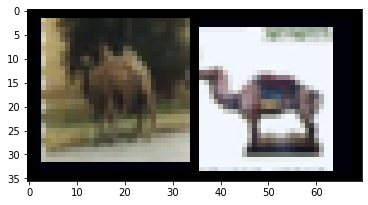

In [20]:
inputs, targets = next(iter(trainloader))
#inputs, targets = inputs.cuda(), targets.cuda()
print(inputs.size(), targets.size())

split_idx = inputs.size(0) // 2
grid = torchvision.utils.make_grid(torch.stack((inputs[0], inputs[split_idx]), 0), normalize=True)
plt.imshow(np.transpose(grid.numpy(), (1,2,0)))

inputs, targets = inputs.cuda(), targets.cuda()
targets_ = targets[0]
outputs = net(inputs[:split_idx])

with torch.no_grad():
    outputs_cls = net(inputs[split_idx:])

outputs_ = outputs[0]
outputs_cls_ = outputs_cls[0]

predict_prob = torch.softmax(outputs_cls_/args.temp, 0)
target_prob = torch.softmax(outputs_/args.temp, 0)

print(targets_)
print(predict_prob, predict_prob[targets_])
print(target_prob, target_prob[targets_])

In [21]:
torch.topk(target_prob, 3)

torch.return_types.topk(
values=tensor([0.1203, 0.0145, 0.0139], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([15, 19, 31], device='cuda:0'))

In [38]:
trainloader.dataset.base_dataset.classes[15]

'camel'